# Machine Learning Course - Final Project

**Author**: *Chrysoula Moschou* (cmosch@csd.auth.gr)

**[Github repository](https://github.com/moschouChry/DWS-ML-Rock-Scissors-Paper-Agent)**

# Import libraries and mount drive

In [34]:
import os
import cv2
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.util import random_noise
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    VotingClassifier,
)
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression


In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset creation and preprocessing class

In [27]:
class dataset:

    def __init__(self, data_path, downsize_ratio=1, new_dimensions = []):
        """
        Initialize the dataset class with file path, downsize ratio, and new dimensions.
        Args:
            data_path (str): Path to the dataset directory.
            downsize_ratio (float): Ratio for downsizing the images.
            new_dimensions (list): New dimensions to resize images to, if provided.
        """
        self.filepath = data_path
        self.downsize_ratio = downsize_ratio
        self.normalized_images = np.empty(shape=(0,))
        self.image_labels = np.empty(shape=(0,))
        self.categories = ['rock', 'paper', 'scissors']
        self.new_dimensions = new_dimensions


    def load_and_process_images(self):
        """
        Load and process images from the dataset.
        This method loads images in grayscale, applies downsizing and resizing, and then normalizes them.
        """
        images = []
        labels = []

        for category in self.categories:
            path = os.path.join(self.filepath, category)
            class_num = self.categories.index(category)

            for img in os.listdir(path):
                try:
                    img_path = os.path.join(path, img)
                    # Load image in grayscale
                    img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    # Downsize image according to downsize_ratio
                    original_height = img_array.shape[0]
                    original_width = img_array.shape[1]
                    img_downsized = cv2.resize(img_array, (int(original_width*self.downsize_ratio),int(original_height*self.downsize_ratio)))
                    if len(self.new_dimensions) == 0:
                        img_resized = img_downsized
                    else:
                        # Resize image to specific dimensions
                        img_resized = cv2.resize(img_downsized, (int(self.new_dimensions[0]),int(self.new_dimensions[1])))
                    images.append(img_resized)
                    labels.append(class_num)
                except Exception as e:
                    pass  # If there's an error, skip this image

        # Convert lists images and labels to array
        images = np.array(images)
        self.image_labels = np.array(labels)

        # Normalize image
        max_pixel_before = np.max(images)
        min_pixel_before = np.min(images)
        print("Before Normalization")
        print(f"Minimum Value: {min_pixel_before}, Maximum Value: {max_pixel_before}")
        num_images, height, width = images.shape
        # Flatten the images into a 2D array (num_images, height*width)
        images_flattened = images.reshape(num_images, -1)
        # Initialize the MinMaxScaler
        scaler = MinMaxScaler()
        # Normalize the flattened image data
        images_normalized_flat = scaler.fit_transform(images_flattened)
        # Reshape back to the original 3D format
        self.normalized_images = images_normalized_flat.reshape(num_images, height, width)
        max_pixel_after = np.max(self.normalized_images)
        min_pixel_after = np.min(self.normalized_images)
        print("After Normalization")
        print(f"Minimum Value: {min_pixel_after}, Maximum Value: {max_pixel_after}")


    def print_dataset_size(self):
        """
        Print the size of the dataset.
        Outputs the number of images and labels in the dataset.
        """
        print("\nDataset size")
        print("------------")
        print(f"Images size: {self.normalized_images.shape}")
        print(f"Labels size: {self.image_labels.shape}")



    def display_random_images_per_class(self):
        """
        Display random images from each class in the dataset.
        It selects a random image from each class and displays it.
        """
        print("\nRandom images from each class")
        print("-----------------------------")
        unique_classes = set(self.image_labels)
        num_unique_classes = len(unique_classes)

        fig, axes = plt.subplots(1, num_unique_classes, figsize=(12, 4))  # Adjust figsize as needed

        for i, class_name in enumerate(unique_classes):
            # Find the indices of images corresponding to the current class
            class_indices = [j for j, label in enumerate(self.image_labels) if label == class_name]

            # Choose a random index from the current class
            random_index = random.choice(class_indices)
            random_image = self.normalized_images[random_index]

            # Display the image
            ax = axes[i]
            ax.imshow(random_image, cmap='gray')  # Use cmap='gray' for grayscale images
            ax.set_title(f'Class: {self.categories[class_name]}')
            ax.axis('off')  # Hide the axis

        plt.tight_layout()
        plt.savefig("random_images.png", bbox_inches='tight', dpi = 600)
        plt.show()


    def split_train_test_set(self, test_set_ratio):
        """
        Split the dataset into training and testing sets.
        Args:
            test_set_ratio (float): The ratio of the dataset to be used as the test set.
        Returns:
            tuple: Contains training and testing sets for both features and labels.
        """
        flattened_images = self.normalized_images.reshape(self.normalized_images.shape[0], -1)

        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(flattened_images, self.image_labels, test_size=test_set_ratio, stratify=self.image_labels)

        print("\nDatasets for training and testing")
        print("---------------------------------")
        print(f"Train set size: {X_train.shape}")
        print(f"Test set size: {X_test.shape}")

        return X_train, X_test, y_train, y_test


# SmartAgent class

In [39]:
class SmartAgent:

    def __init__(self):
        """
        Initialize the SmartAgent class.
        This class manages different classifiers for the intelligent game agent.
        """

        self.availableClassifiers = {
            'NN': MLPClassifier(random_state=42),
            'SVC': SVC(random_state=42),
            'RandomForest': RandomForestClassifier(random_state=42),
            'AdaBoost': AdaBoostClassifier(random_state=42)
        }
        self.mainClassifier = None

    def test_multiple_classifiers(self, X_train, y_train, n_splits = 5):
        """
        Test and evaluate multiple classifiers using cross-validation.
        Args:
            X_train (array): Training data features.
            y_train (array): Training data labels.
            n_splits (int): Number of folds for k-fold cross-validation.
        """

        # Initialize DataFrame to store results
        results_training = pd.DataFrame(columns=['Model', 'Parameters',
                                                'Accuracy',
                                                'Precision (micro)',
                                                'Recall (micro)',
                                                'F1_score (micro)',
                                                'Precision (macro)',
                                                'Recall (macro)',
                                                'F1_score (macro)'
                                                ])

        # Define the scoring metrics as a dictionary
        scoring = {
            'Accuracy': make_scorer(accuracy_score),
            'Precision (micro)': make_scorer(precision_score, average='micro'),
            'Recall (micro)': make_scorer(recall_score, average='micro'),
            'F1_score (micro)': make_scorer(f1_score, average='micro'),
            'Precision (macro)': make_scorer(precision_score, average='macro'),
            'Recall (macro)': make_scorer(recall_score, average='macro'),
            'F1_score (macro)': make_scorer(f1_score, average='macro'),
        }

        # Perform k-fold cross-validation for each classifier
        for model_name, model in self.availableClassifiers.items():

            print(f"Training {model_name}")
            # Define the StratifiedKFold cross-validator
            stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

            # Define hyperparameters and ranges for grid search
            hyperparameters = {}
            best_params = None

            if model_name == 'NN':
                hyperparameters = {
                      'max_iter': [1000],
                      'learning_rate_init': [0.0001, 0.001],
                      'hidden_layer_sizes': [(100, 50), (100, 100), (200, 100)],
                      'solver': ['adam', 'sgd']
                  }

            elif model_name == 'SVC':
                hyperparameters = {
                    'C': [0.1, 1, 10],
                    'kernel': ['linear', 'rbf', 'poly']
                }

            elif model_name == 'RandomForest':
                hyperparameters = {
                    'n_estimators': [100, 200, 300],
                    'min_samples_split': [2, 5, 10]
                }

            elif model_name == 'AdaBoost':
                hyperparameters = {
                    'n_estimators': [200, 300, 400],
                    'learning_rate': [0.1, 0.5, 1.0]
                }

            # Perform grid search with cross-validation
            grid_search = GridSearchCV(model, hyperparameters, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=4)
            grid_search.fit(X_train, y_train)
            best_params = grid_search.best_params_
            model = grid_search.best_estimator_

            # Perform cross-validation and compute metrics for each fold
            results = cross_validate(grid_search.best_estimator_, X_train, y_train, cv=stratified_kfold, scoring=scoring)

            # Compute metrics for each fold
            metrics_train = {
                'Model': model_name,
                'Parameters': best_params,
                'Accuracy': np.mean(results['test_Accuracy']),
                'Precision (micro)': np.mean(results['test_Precision (micro)']),
                'Recall (micro)': np.mean(results['test_Recall (micro)']),
                'F1_score (micro)': np.mean(results['test_F1_score (micro)']),
                'Precision (macro)': np.mean(results['test_Precision (macro)']),
                'Recall (macro)': np.mean(results['test_Recall (macro)']),
                'F1_score (macro)': np.mean(results['test_F1_score (macro)']),
            }

            # Append results to the DataFrame
            results_training = pd.concat([results_training, pd.DataFrame([metrics_train])], ignore_index=True)

        # Display the results
        display(results_training)


    def test_ensemble_classifiers(self, X_train, y_train, base_learners, n_splits = 5):
        """
        Test ensemble classifiers like stacking and voting classifiers.
        Args:
            X_train (array): Training data features.
            y_train (array): Training data labels.
            base_learners (list): Base learners for ensemble methods.
            n_splits (int): Number of folds for k-fold cross-validation.
        """

        # Initialize DataFrame to store results
        results_training = pd.DataFrame(columns=['Model',
                                                'Accuracy',
                                                'Precision (micro)',
                                                'Recall (micro)',
                                                'F1_score (micro)',
                                                'Precision (macro)',
                                                'Recall (macro)',
                                                'F1_score (macro)'
                                                ])

        # Define the scoring metrics as a dictionary
        scoring = {
            'Accuracy': make_scorer(accuracy_score),
            'Precision (micro)': make_scorer(precision_score, average='micro'),
            'Recall (micro)': make_scorer(recall_score, average='micro'),
            'F1_score (micro)': make_scorer(f1_score, average='micro'),
            'Precision (macro)': make_scorer(precision_score, average='macro'),
            'Recall (macro)': make_scorer(recall_score, average='macro'),
            'F1_score (macro)': make_scorer(f1_score, average='macro'),
        }

        # Define your classifiers
        classifiers = {
            #'Stacking': StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression(), n_jobs=-1),
            'Voting Hard' : VotingClassifier(estimators=base_learners, voting='hard', n_jobs=-1),
            'Voting Soft' : VotingClassifier(estimators=base_learners, voting='soft', n_jobs=-1)
        }

        # Perform k-fold cross-validation for each classifier
        for model_name, model in classifiers.items():

            print(f"Training {model_name}")
            # Define the StratifiedKFold cross-validator
            stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

            # Perform cross-validation and compute metrics for each fold
            results = cross_validate(model, X_train, y_train, cv=stratified_kfold, scoring=scoring)

            # Compute metrics for each fold
            metrics_train = {
                'Model': model_name,
                'Accuracy': np.mean(results['test_Accuracy']),
                'Precision (micro)': np.mean(results['test_Precision (micro)']),
                'Recall (micro)': np.mean(results['test_Recall (micro)']),
                'F1_score (micro)': np.mean(results['test_F1_score (micro)']),
                'Precision (macro)': np.mean(results['test_Precision (macro)']),
                'Recall (macro)': np.mean(results['test_Recall (macro)']),
                'F1_score (macro)': np.mean(results['test_F1_score (macro)']),
            }

            # Append results to the DataFrame
            results_training = pd.concat([results_training, pd.DataFrame([metrics_train])], ignore_index=True)

        # Display the results
        display(results_training)

    def train_classifier(self, classifier, train_data, train_labels):
        """
        Train the specified classifier with the provided data.
        Args:
            classifier (model): The classifier to train.
            train_data (array): Training data features.
            train_labels (array): Training data labels.
        """
        self.mainClassifier = classifier
        self.mainClassifier.fit(train_data, train_labels)

    def classify_image(self, image):
        """
        Classify a single image using the trained classifier.
        Args:
            image (array): The image to classify.
        Returns:
            int: The predicted class label.
        """
        return self.mainClassifier.predict([image])[0]

    def play(self, image):
        """
        Determine the game move based on the classified image.
        Args:
            image (array): The image to classify for gameplay.
        Returns:
            tuple: The game move and predicted label.
        """
        predicted_label = self.classify_image(image)
        if predicted_label == 0:   # Rock
            move = 2    # Paper
        elif predicted_label == 1: # Scissors
            move = 0    # Rock
        elif predicted_label == 2: # Paper
            move = 1     # Scissors
        return move, predicted_label

# RandomAgent class

In [29]:
class RandomAgent:

    def __init__(self, images_set, labels_set, p_vertical_flip=0.5, p_horizontal_flip=0.5, noise_sigma=0.15):
        """
        Initialize the RandomAgent class.
        Args:
            images_set (array): Set of images for the agent to use.
            labels_set (array): Corresponding labels for the images.
            p_vertical_flip (float): Probability of applying vertical flip to an image.
            p_horizontal_flip (float): Probability of applying horizontal flip to an image.
            noise_sigma (float): Standard deviation of Gaussian noise to be added to images.
        """
        self.images = images_set
        self.labels = labels_set
        self.p_vertical_flip = p_vertical_flip
        self.p_horizontal_flip = p_horizontal_flip
        self.noise_sigma = noise_sigma

    def apply_vertical_flip(self, image):
        """
        Apply vertical flip to an image with a probability p_vertical_flip.
        Args:
            image (array): The image to potentially flip.
        Returns:
            array: Vertically flipped image or original image.
        """
        if random.random() < self.p_vertical_flip:
            fliped_image = np.flipud(image.reshape(1,-1))
            return fliped_image.reshape(-1)
        return image

    def apply_horizontal_flip(self, image):
        """
        Apply horizontal flip to an image with a probability p_horizontal_flip.
        Args:
            image (array): The image to potentially flip.
        Returns:
            array: Horizontally flipped image or original image.
        """
        if random.random() < self.p_horizontal_flip:
            fliped_image = np.fliplr(image.reshape(1,-1))
            return fliped_image.reshape(-1)
        return image

    def apply_noise(self, image):
        """
        Apply Gaussian noise to an image.
        Args:
            image (array): The image to add noise to.
        Returns:
            array: Image with added Gaussian noise.
        """
        # Genearte noise with same shape as that of the image
        noise = np.random.normal(0, self.noise_sigma, image.shape)
        noisy_array = image + noise
        # Clipping the values to ensure they are within [0, 1]
        noisy_array_clipped = np.clip(noisy_array, 0, 1)
        return noisy_array_clipped

    def play(self, biasedMove=None):
        """
        Selects and processes an image for the game play.
        Args:
            biasedMove (int, optional): Specific label to bias the selection towards.
        Returns:
            tuple: Processed image and its label.
        """
        if biasedMove is None:
          index = random.randint(0, len(self.images) - 1)
          image = self.images[index]
          label = self.labels[index]
        else:
          # Filter images that have the specified label
          valid_indices = [i for i, l in enumerate(self.labels) if l == biasedMove]
          if not valid_indices:
              raise ValueError("No images with the specified label found")
          # Choose a random image with the specified label
          index = random.choice(valid_indices)
          image = self.images[index]
          label = self.labels[index]

        image = self.apply_vertical_flip(image)
        image = self.apply_horizontal_flip(image)
        image = self.apply_noise(image)
        return image, label

# Game Enviroment Class

In [37]:
class gameEnviroment:

    def __init__(self, win_reward = 2, tie_reward = 1, loss_reward = 0, bet_amount = 1):
        """
        Initialize the game environment with reward and bet settings.
        Args:
            win_reward (int): Reward for winning a round for Player 2.
            tie_reward (int): Reward for tying a round for Player 2.
            loss_reward (int): Reward (or penalty) for losing a round for Player 2.
            bet_amount (int): Betting amount for each round for Player 2.
        """
        self.win_reward = win_reward
        self.tie_reward = tie_reward
        self.loss_reward = loss_reward
        self.bet_amount = bet_amount


    def player2_reward(self, player1_move, player2_move):
        """
        Calculate the reward for Player 2 based on the moves of both players.
        Args:
            player1_move (int): Move of Player 1.
            player2_move (int): Move of Player 2.
        Returns:
            int: The reward for Player 2 for the round.
        """
        # Rock(0) beats Scissors(1), Scissors(1) beats Paper(2), Paper(2) beats Rock(0)
        if player2_move == player1_move:
            return self.tie_reward
        elif (player2_move == 0 and player1_move == 1) or (player2_move == 1 and player1_move == 2) or (player2_move == 2 and player1_move == 0):
            return self.win_reward
        else:
            return self.loss_reward

    def move_to_name(self, move):
        """
        Convert move integer to its corresponding name.
        Args:
            move (int): The move represented as an integer.
        Returns:
            str: The name of the move.
        """
        move_names = {0: 'Rock', 1: 'Scissors', 2: 'Paper'}
        return move_names.get(move, "None")

    def game(self, rounds, biased_move, player1_agent, player2_agent, print_gain_history=True, verbose=False, print_results=True):
        """
        Simulate a game with a specified number of rounds.
        Args:
            rounds (int): Number of rounds to play.
            biased_move (int): Biased move for Player 1.
            player1_agent (object): Agent representing Player 1.
            player2_agent (object): Agent representing Player 2.
            print_gain_history (bool): Flag to print wallet history.
            verbose (bool): Flag for verbose output.
            print_results (bool): Flag to print final results.
        Returns:
            tuple: Total gain history in percentage and accuracy of Player 2.
        """
        # We assume that Player's 2 wallet has enough money to bet for the rounds of the game
        player2_init_wallet = self.bet_amount*rounds

        # List to store Player's 2 wallet throughout the game
        player2_wallet_history = []
        player2_wallet_history.append(player2_init_wallet)

        max_possible_reward = (self.win_reward-self.bet_amount)*rounds

        # List to store Player's 1 moves
        player1_moves = []
        # List to store Player's 2 predictions for player's 1 moves
        player2_predicted_moves = []

        for i in range(1,rounds+1):

            # Remove bet_amount from Player's 2 wallet
            player2_wallet = player2_wallet_history[-1]
            player2_wallet -= self.bet_amount

            player1_image, player1_move = player1_agent.play(biased_move)
            player2_move, player2_prediction = player2_agent.play(player1_image)
            round_reward = self.player2_reward(player1_move, player2_move)
            player2_wallet += round_reward
            player2_wallet_history.append(player2_wallet)

            player1_moves.append(player1_move)
            player2_predicted_moves.append(player2_prediction)

            if verbose:
                print(f"Round {i}")
                print(f"Player 1: {self.move_to_name(player1_move)} - Player 2: {self.move_to_name(player2_move)}")


        total_gain_history = [(player2Wallet - player2_init_wallet) for player2Wallet in player2_wallet_history]
        total_gain_history_percent = [(total_gain/player2_init_wallet)*100 for total_gain in total_gain_history]
        accuracy = accuracy_score(player1_moves, player2_predicted_moves)

        if print_results:
            # Results at the end of the game
            print(f"Player 2 started playing with {player2_init_wallet} € and ended up with {player2_wallet_history[-1]} €")
            print(f"Total gain: {total_gain_history[-1]} € / {total_gain_history_percent[-1]} %")
            print(f"Player's 2 accuracy in identifying Player's 1 moves : {accuracy}")

        if print_gain_history:
            # Plotting the wallet of Player 2 throught the game

            max_possible_gain = (self.win_reward - self.bet_amount)/self.bet_amount
            plt.figure()
            plt.plot(total_gain_history_percent, label="Player's 2 gain")
            plt.axhline(y=max_possible_gain*100, color='red', linestyle='--', label="Maximum gain")

            if biased_move == None:
              plt.title(f'Player 2 Total Gain (%) Over Rounds \n(Player 1: Random Moves)')
            else:
              plt.title(f"Player 2 Total Gain (%) Over Rounds \n(Player 1: {self.move_to_name(biased_move)} bias)")
            plt.xlabel('Round')
            plt.ylabel('Total Gain (%)')
            plt.grid(True)
            plt.legend()
            plt.show()

        return total_gain_history_percent, accuracy

# Main Experiment Setup

## Load images

Before Normalization
Minimum Value: 2, Maximum Value: 252
After Normalization
Minimum Value: 0.0, Maximum Value: 1.0000000000000002

Dataset size
------------
Images size: (2188, 20, 30)
Labels size: (2188,)

Random images from each class
-----------------------------


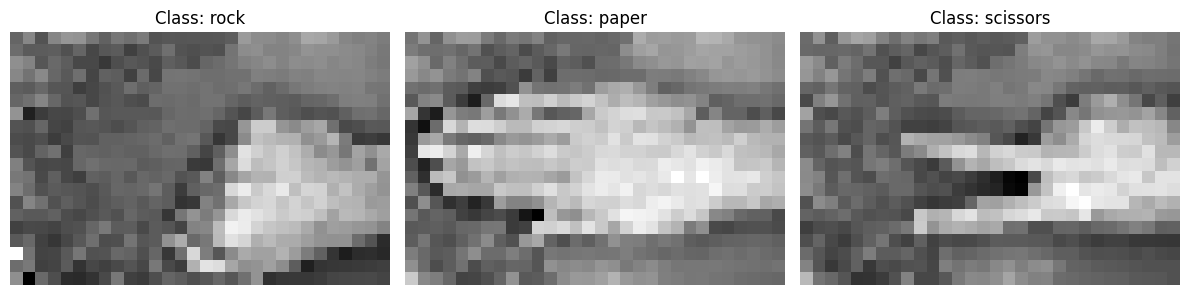

In [31]:
# Update the path to the correct data folder
data_path = '/content/drive/MyDrive/Colab Notebooks/DWS master/1rst semester/Machine Learning Course/Project/data'

# Define the new height for the images
downsize_ratio = 0.1

kaggle_dataset = dataset(data_path, downsize_ratio)

kaggle_dataset.load_and_process_images()
kaggle_dataset.print_dataset_size()
kaggle_dataset.display_random_images_per_class()

## Split into train test set

In [40]:
test_set_ratio = 0.3

X_train, X_test, y_train, y_test = kaggle_dataset.split_train_test_set(test_set_ratio)


Datasets for training and testing
---------------------------------
Train set size: (1531, 600)
Test set size: (657, 600)


## Test different classifiers on the Train Set

In [41]:
testAgent = SmartAgent()

testAgent.test_multiple_classifiers(X_train, y_train)

Training NN
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Training SVC
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training RandomForest
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training AdaBoost
Fitting 5 folds for each of 9 candidates, totalling 45 fits


,Model,Parameters,Accuracy,Precision (micro),Recall (micro),F1_score (micro),Precision (macro),Recall (macro),F1_score (macro)
0,NN,"{'hidden_layer_sizes': (200, 100), 'learning_r...",0.916393,0.916393,0.916393,0.916393,0.918488,0.915989,0.916118
1,SVC,"{'C': 10, 'kernel': 'rbf'}",0.911166,0.911166,0.911166,0.911166,0.913231,0.910716,0.911122
2,RandomForest,"{'min_samples_split': 2, 'n_estimators': 200}",0.928151,0.928151,0.928151,0.928151,0.929469,0.927707,0.927810
3,AdaBoost,"{'learning_rate': 1.0, 'n_estimators': 400}",0.829522,0.829522,0.829522,0.829522,0.833707,0.829782,0.829669


In [42]:
base_1 = MLPClassifier(hidden_layer_sizes=(200, 100),learning_rate_init=0.0001, max_iter=1000, solver='adam', random_state=42)
base_2 = SVC(C=10, kernel='rbf', random_state=42, probability=True)
base_3 = RandomForestClassifier(min_samples_split=2, n_estimators=200, n_jobs = -1, random_state = 42)
base_4 = AdaBoostClassifier(learning_rate=1.0,n_estimators=400, random_state=42)

base_learners = [ ('NN', base_1), ('SVC', base_2), ('RandomForest', base_3), ('AdaBoost', base_4)]
testAgent = SmartAgent()
testAgent.test_ensemble_classifiers(X_train, y_train, base_learners)

Training Voting Hard
Training Voting Soft


,Model,Accuracy,Precision (micro),Recall (micro),F1_score (micro),Precision (macro),Recall (macro),F1_score (macro)
0,Voting Hard,0.926848,0.926848,0.926848,0.926848,0.927714,0.926541,0.926515
1,Voting Soft,0.926193,0.926193,0.926193,0.926193,0.927495,0.925812,0.925939


## Create a RandomAgent for player 1

In [50]:
player1Agent = RandomAgent(X_test, y_test)

## Choose the best classifier and create a SmartAgent for Player 2

In [44]:
clf = RandomForestClassifier(min_samples_split=2, n_estimators=200, n_jobs = -1, random_state = 42)

player2Agent = SmartAgent()
player2Agent.train_classifier(clf,X_train,y_train)

## Create a gaming enviroment for the 2 Players

Player 2 started playing with 100 € and ended up with 190 €
Total gain: 90 € / 90.0 %
Player's 2 accuracy in identifying Player's 1 moves : 0.94
Player 2 started playing with 100 € and ended up with 193 €
Total gain: 93 € / 93.0 %
Player's 2 accuracy in identifying Player's 1 moves : 0.95
Player 2 started playing with 100 € and ended up with 189 €
Total gain: 89 € / 89.0 %
Player's 2 accuracy in identifying Player's 1 moves : 0.92
Player 2 started playing with 100 € and ended up with 192 €
Total gain: 92 € / 92.0 %
Player's 2 accuracy in identifying Player's 1 moves : 0.96


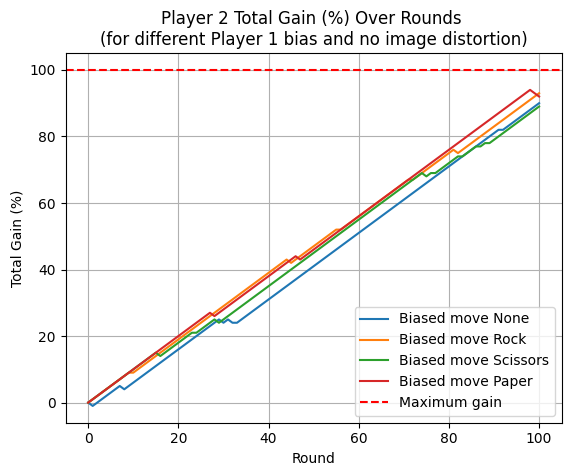

In [49]:
# Create the gaming enviroment
enviroment = gameEnviroment()

# Set the desired amount of rounds
rounds = 100

biasedMoves = [None, 0, 1, 2]

plt.figure()
max_possible_gain = (enviroment.win_reward - enviroment.bet_amount)/enviroment.bet_amount

# player1Agent = RandomAgent(X_test, y_test, p_vertical_flip=0, p_horizontal_flip=0, noise_sigma=0)

for biasedMove_player1 in biasedMoves:

  # Simulate the game
  total_gain_history_percent, accuracy = enviroment.game(rounds,
                                                         biasedMove_player1,
                                                         player1Agent,
                                                         player2Agent,
                                                         print_gain_history=False)


  plt.plot(total_gain_history_percent, label=f"Biased move {enviroment.move_to_name(biasedMove_player1)}")


plt.axhline(y=max_possible_gain*100, color='red', linestyle='--', label="Maximum gain")
plt.title(f"Player 2 Total Gain (%) Over Rounds \n(for different Player 1 bias)")
plt.xlabel('Round')
plt.ylabel('Total Gain (%)')
plt.grid(True)
plt.legend()

plt.savefig("game_example_2.png", bbox_inches='tight', dpi = 600)
plt.show()

# Analysis of Classifier Performance in Varied Game Conditions

In [51]:
base_1 = MLPClassifier(hidden_layer_sizes=(200, 100),learning_rate_init=0.0001, max_iter=1000, solver='adam', random_state=42)
base_2 = SVC(C=10, kernel='rbf', random_state=42, probability=True)
base_3 = RandomForestClassifier(min_samples_split=2, n_estimators=200, n_jobs = -1, random_state = 42)
base_4 = AdaBoostClassifier(learning_rate=1.0,n_estimators=400, random_state=42)

base_learners = [ ('NN', base_1), ('SVC', base_2), ('RandomForest', base_3), ('AdaBoost', base_4)]

classifiers = {
    'Voting Hard' : VotingClassifier(estimators=base_learners, voting='hard'),
    'Voting Soft' : VotingClassifier(estimators=base_learners, voting='soft'),
    'NN' : base_1,
    'SVC': base_2,
    'RandomForest': base_3,
    'AdaBoost': base_4
}

In [65]:
results = pd.DataFrame(columns = ['Biased Move','Model','Gain','Accuracy'])

# Create the gaming enviroment
env = gameEnviroment()

# Set the desired amount of rounds
rounds = 200

biasedMoves = [None, 0, 1, 2]

player1Agent = RandomAgent(X_test, y_test)

for model_name, model in classifiers.items():

    print(model_name)
    player2Agent = SmartAgent()
    player2Agent.train_classifier(model, X_train, y_train)

    for biasedMove_player1 in biasedMoves:
        # Simulate the game
        gain ,accuracy = env.game(rounds, biasedMove_player1, player1Agent, player2Agent, print_gain_history = False, print_results=False)

        move_and_model_result = {
            'Biased Move': env.move_to_name(biasedMove_player1),
            'Model': model_name,
            'Gain': gain[-1],
            'Accuracy': accuracy
          }
        results = pd.concat([results, pd.DataFrame([move_and_model_result])], ignore_index=True)

Voting Hard
Voting Soft
NN
SVC
RandomForest
AdaBoost


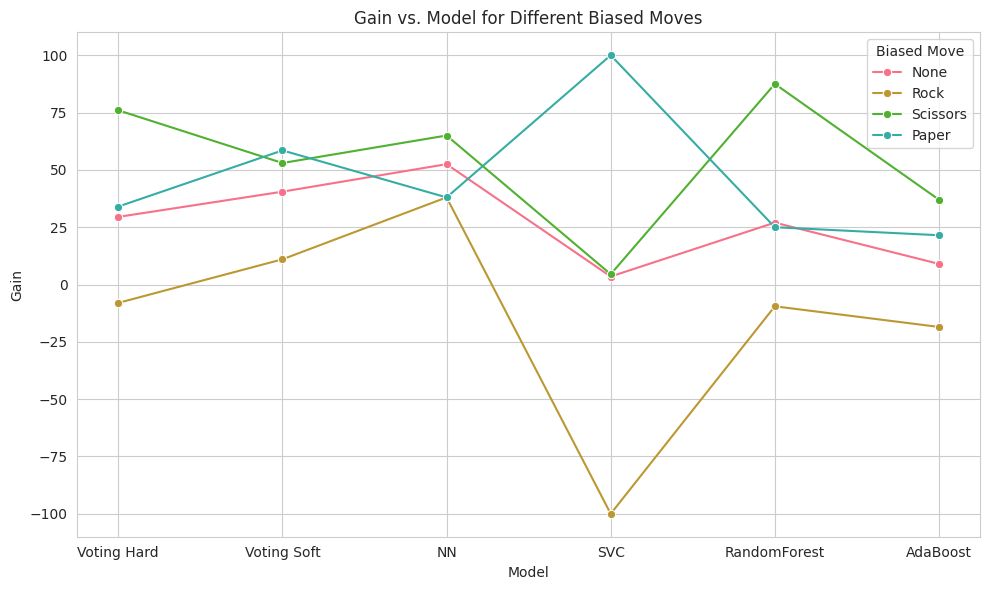

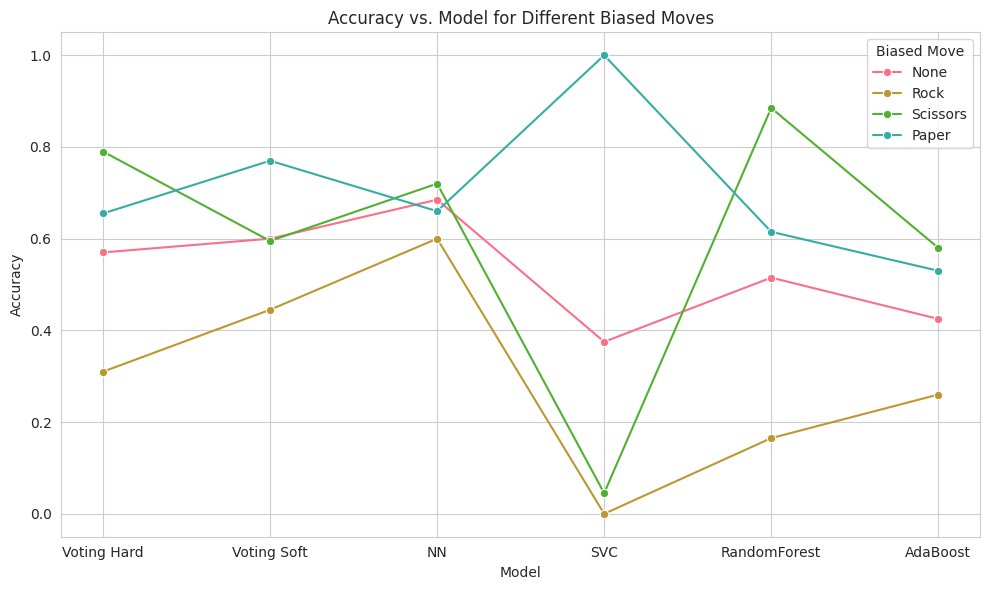

In [68]:
# Create the first plot for Gain
plt.figure(figsize=(10, 6))
sns.set_palette("husl")
sns.set_style("whitegrid")

# Plot for Gain
sns.lineplot(data=results, x='Model', y='Gain', hue='Biased Move', marker='o', errorbar=None)
plt.title('Gain vs. Model for Different Biased Moves')
plt.xlabel('Model')
plt.ylabel('Gain')
plt.legend(title='Biased Move', loc='best')
plt.tight_layout()

plt.savefig("gain_different_models.png",dpi=600, bbox_inches='tight')
# Show the first plot
plt.show()


plt.figure(figsize=(10, 6))

# Plot for Accuracy
sns.lineplot(data=results, x='Model', y='Accuracy', hue='Biased Move', marker='o', errorbar=None)
plt.title('Accuracy vs. Model for Different Biased Moves')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.legend(title='Biased Move', loc='best')
plt.tight_layout()

plt.savefig("accuracy_different_models.png",dpi=600, bbox_inches='tight')
# Show the second plot
plt.show()
